# Transition State Search: O Diffusion on Pt(111) using NEB

In this case study, we use the **Nudged Elastic Band (NEB)** method to determine the minimum energy path (MEP) and activation energy barrier for the diffusion of an O adatom from an **fcc site** to an **hcp site** on a Pt(111) surface.

**Workflow:**
1. Build the Pt(111) slab.  
2. Place O adatom in the *fcc* site and optimize → **initial state**.  
3. Place O adatom in the *hcp* site and optimize → **final state**.  
4. Generate intermediate images and construct the NEB band.  
5. Optimize the NEB band to find the minimum energy path.  
6. Plot the NEB band to extract activation energy and barrier profile.  

This illustrates how ML-based potentials (FairChem) enable efficient transition state searches in heterogeneous catalysis.

## Further Reading

For more details, see [FAIRChem documentation](https://fair-chem.github.io/uma_tutorials/uma_tutorial.html#transition-states-nebs).


In [1]:
from ase.build import add_adsorbate, fcc111, molecule
from ase.optimize import LBFGS
from fairchem.core import FAIRChemCalculator, pretrained_mlip
from ase.mep import NEB, NEBTools
from ase.io import Trajectory
from ase.visualize import view

# --- Step 1: Setup FairChem Calculator ---
predictor = pretrained_mlip.get_predict_unit("uma-s-1", device="cpu")
calc = FAIRChemCalculator(predictor, task_name="oc20")

# --- Step 2: Initial state (O in fcc site) ---
initial = fcc111("Pt", (3, 3, 3), vacuum=8, periodic=True)
adsorbate = molecule("O")
add_adsorbate(initial, adsorbate, 2.0, "fcc")
initial.calc = calc
opt = LBFGS(initial)
opt.run(fmax=0.01, steps=100)
print("Initial state energy:", initial.get_potential_energy())

# --- Step 3: Final state (O in hcp site) ---
final = fcc111("Pt", (3, 3, 3), vacuum=8, periodic=True)
adsorbate = molecule("O")
add_adsorbate(final, adsorbate, 2.0, "hcp")
final.calc = FAIRChemCalculator(predictor, task_name="oc20")
opt = LBFGS(final)
opt.run(fmax=0.01, steps=100)
print("Final state energy:", final.get_potential_energy())

W0913 23:53:14.220796 48864 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


       Step     Time          Energy          fmax
LBFGS:    0 23:53:18     -141.329803        3.509945
LBFGS:    1 23:53:18     -141.719924        3.515033
LBFGS:    2 23:53:19     -142.980937        2.978364
LBFGS:    3 23:53:19     -143.684050        0.968213
LBFGS:    4 23:53:19     -143.787047        1.271653
LBFGS:    5 23:53:20     -143.858776        0.874621
LBFGS:    6 23:53:20     -143.933926        0.170929
LBFGS:    7 23:53:20     -143.937116        0.152466
LBFGS:    8 23:53:21     -143.944597        0.122212
LBFGS:    9 23:53:21     -143.948828        0.109262
LBFGS:   10 23:53:21     -143.952234        0.069951
LBFGS:   11 23:53:22     -143.953715        0.080120
LBFGS:   12 23:53:22     -143.955175        0.083500
LBFGS:   13 23:53:22     -143.956798        0.066270
LBFGS:   14 23:53:23     -143.958313        0.031468
LBFGS:   15 23:53:23     -143.959037        0.026420
LBFGS:   16 23:53:24     -143.959278        0.022171
LBFGS:   17 23:53:24     -143.959439        0.01

In [2]:
# Make sure the structures are correct:
view([initial, final], viewer="ngl")

In [3]:
# --- Step 4: Setup NEB images ---
images = [initial]
for i in range(3):  # 3 intermediate images
    image = initial.copy()
    image.calc = FAIRChemCalculator(predictor, task_name="oc20")
    images.append(image)
images.append(final)

# --- Step 5: Construct NEB band ---
neb = NEB(images)
neb.interpolate()

# Optimize NEB
opt = LBFGS(neb, trajectory="neb.traj")
opt.run(fmax=0.05, steps=100)

       Step     Time          Energy          fmax
LBFGS:    0 23:54:01     -143.192768        3.057364
LBFGS:    1 23:54:02     -143.359404        1.474606
LBFGS:    2 23:54:03     -143.410682        0.464277
LBFGS:    3 23:54:05     -143.422910        0.452617
LBFGS:    4 23:54:06     -143.442601        0.484322
LBFGS:    5 23:54:07     -143.459097        0.383559
LBFGS:    6 23:54:08     -143.469954        0.213784
LBFGS:    7 23:54:09     -143.475163        0.168626
LBFGS:    8 23:54:10     -143.476046        0.210974
LBFGS:    9 23:54:11     -143.477464        0.181440
LBFGS:   10 23:54:12     -143.478936        0.160192
LBFGS:   11 23:54:13     -143.479462        0.087441
LBFGS:   12 23:54:14     -143.479610        0.087808
LBFGS:   13 23:54:15     -143.479892        0.106212
LBFGS:   14 23:54:16     -143.480418        0.121387
LBFGS:   15 23:54:18     -143.481025        0.086837
LBFGS:   16 23:54:19     -143.481420        0.052712
LBFGS:   17 23:54:20     -143.481723        0.04

np.True_

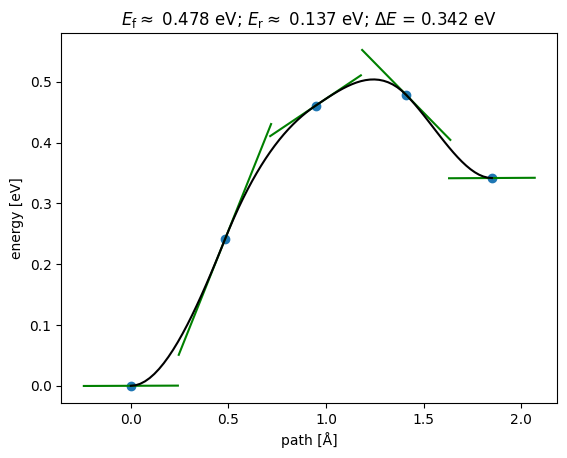

In [4]:
# --- Step 6: Analyze band ---
NEBTools(neb.images).plot_band();

In [5]:
# Load and visualize NEB trajectory interactively
traj = Trajectory("neb.traj")
print(f"NEB trajectory contains {len(traj)} frames.")

view(traj, viewer="ngl")

NEB trajectory contains 90 frames.
